### **Team -11, Predicting Protein Interaction using GCNs on Yeast Dataset**

**Note:** This notebook uses CUDA v.10.1. If your PC is not supported, run this notebook on Colab with GPU settings turned on.

In [ ]:
!pip install stellargraph

     |████████████████████████████████| 440kB 4.7MB/s 


In [ ]:
from stellargraph.data import EdgeSplitter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score,roc_curve,auc,classification_report,precision_recall_curve
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import pandas as pd
import networkx as nx
import os
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
!pip install dgl-cu101

     |████████████████████████████████| 16.9MB 200kB/s 


In [ ]:
import dgl
from dgl import DGLGraph
dgl.load_backend('pytorch')
from dgl.nn.pytorch import conv as dgl_conv

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch
Using backend: pytorch


In [ ]:
class GCNModel(nn.Module):
    def __init__(self,in_feats,n_hidden,out_dim,layer_dim,hidden_layer_dim):
        super(GCNModel, self).__init__()
        

        self.gcn_layer_1 = dgl_conv.GraphConv(in_feats, n_hidden)

        self.gcn_layer_2 = dgl_conv.GraphConv(n_hidden, out_dim)

        self.lin_layer_1 = nn.Linear(out_dim, hidden_layer_dim)

        self.lin_layer_2 = nn.Linear(hidden_layer_dim,1)

    def forward(self, g, features, node_pairs, link_labels):
        x = features
        x = self.gcn_layer_1(g, features)
        x = F.relu(x)

        x = self.gcn_layer_2(g,x)
        x = F.relu(x)

        emb = x

        src = node_pairs[:,0]
        dst = node_pairs[:,1]

        emb_src = x[src]
        emb_dst = x[dst]

        z_tensor = torch.mul(emb_src,emb_dst)
        z_tensor = self.lin_layer_1(z_tensor)
        z_tensor = F.relu(z_tensor)
        z_tensor = self.lin_layer_2(z_tensor)
        sigm = nn.Sigmoid()
        z_tensor = sigm(z_tensor)
        return z_tensor.view(-1),emb
    
    def predict(self, features, g, node_pairs, link_labels):
        pred,emb = self.forward(features, g, node_pairs, link_labels)
        loss = nn.BCELoss()(pred, link_labels)
        return loss, pred,emb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
raw_edge_list = open('/content/drive/My Drive/Colab Notebooks/DSLab/yeast.edgelist','r')
G = nx.Graph()
G = nx.parse_edgelist(raw_edge_list, delimiter='\t', create_using=G,nodetype=str, data=(('weight', float),))
# Get graph edges and nodes from networkx graph object
nodes = G.nodes
edges = G.edges

print("Graph's Nodes : {} / Edges : {}".format(len(nodes), len(edges)))

FileNotFoundError: ignored

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

In [ ]:
es_test = EdgeSplitter(G)
graph_test, examples_test, link_labels_test = es_test.train_test_split(p=0.25, method="global")

** Sampled 132623 positive and 132623 negative edges. **


In [ ]:
es_train = EdgeSplitter(graph_test, G)
graph_train, examples_train, link_labels_train = es_train.train_test_split(
    p=0.7, method="global")
examples_train,examples_val, link_labels_train, link_label_val = train_test_split(examples_train,link_labels_train,test_size=0.033)

** Sampled 334212 positive and 334212 negative edges. **


In [ ]:
def preprocess_graph(adj):
  adj = sp.coo_matrix(adj)
  adj_ = adj + sp.eye(adj.shape[0])
  rowsum = np.array(adj_.sum(1))
  degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
  features = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo() 
  print(features.shape)

  print(type(features))

  indices = np.vstack((features.row, features.col))
  values = features.data
  shape = features.shape
  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)

  features = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()
  return features

In [ ]:
# #features =np.matrix([[i, i] for i in range(adj.shape[0])])
features = preprocess_graph(nx.adjacency_matrix(graph_train))
# #features = Variable(torch.FloatTensor(features), requires_grad=True)
# features

(6526, 6526)
<class 'scipy.sparse.coo.coo_matrix'>


In [ ]:
adj = sp.coo_matrix(nx.adjacency_matrix(G))
adj_ = adj + sp.eye(adj.shape[0])
rowsum = np.array(adj_.sum(1))
degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
degree_mat_inv_sqrt.toarray()

array([[0.03181424, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07235746, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04593152, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.70710678, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.22941573]])

In [ ]:
class EdgeDataset(Dataset):
    def __init__(self, x, y):
        super(EdgeDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def create_model_and_train(lr,batch_size,n_hidden,hidden_layer_dim):
  g = DGLGraph()
  g.from_networkx(graph_train)
  g.readonly()
  n_epochs=20
  out_dim = 80
  model = GCNModel(in_feats = features.shape[0],n_hidden=n_hidden,out_dim=out_dim,layer_dim=out_dim,hidden_layer_dim=hidden_layer_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  traindata = EdgeDataset(examples_train, link_labels_train)
  edge_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
  print("Training for {} epochs.".format(n_epochs))

  eval_report = {
      'train_losses':[],
      'train_rocs':[],
      'train_aps':[],
      'val_losses':[],
      'val_rocs':[],
      'val_aps':[],
      'times_per_epoch':[],
      'epochs':[],
      'learning_rate': list(np.full((n_epochs,),lr)),
      'batch_size':list(np.full((n_epochs,),batch_size)),
      'hidden1_dim':list(np.full((n_epochs,),n_hidden)) ,
      'hidden_layer_dim':list(np.full((n_epochs,),hidden_layer_dim))
  }

  sigm_val_pred = []
  for epoch in range(n_epochs):
    eval_report['epochs'].append(epoch+1)
    t = time.time()
    print('\n', end='')
    
    loss = 0.0
    train_roc = 0.0
    train_ap = 0.0
    embed = []
    for i,data in enumerate(edge_loader):
      #print("Step {}/{}......".format(i+1,))
      pairs, edges = data
      pairs = Variable(pairs).cuda()
      edges = Variable(edges.float()).cuda()
      
      optimizer.zero_grad()
      loss, pred,embed = model.predict(g.to(device),torch.FloatTensor(features).cuda(), pairs, edges)
      loss.backward()
      optimizer.step()

      #pred = F.log_softmax(pred, dim=1)

      pred = pred.detach().to("cpu").numpy()
      #pred = 1*(pred>0.25)
      #pred = np.argmax(pred, axis=1)
      y_pred = []
      y_pred = np.append(y_pred, pred)
      train_roc = roc_auc_score(edges.detach().to("cpu").numpy(), y_pred)
      train_ap = average_precision_score(edges.detach().to("cpu").numpy(), y_pred)
      print("\repoch = {}/{} ({}/{}) - loss = {:.4f} roc_auc_score = {:.4f}"
      .format(epoch+1,n_epochs,i+1,int(examples_train.shape[0]/batch_size),
              loss,train_roc),end='',flush=True)
  
    eval_report['train_losses'].append(float(loss.detach().to('cpu').numpy()))
    eval_report['train_rocs'].append(train_roc)
    eval_report['train_aps'].append(train_ap)
    


    #validation scores
    val_loss, val_pred,_ = model.predict(g.to(device),torch.FloatTensor(features).cuda(), 
                                      torch.tensor(examples_val).cuda(), 
                                      torch.FloatTensor(link_label_val).cuda())
    #val_pred = F.log_softmax(val_pred, dim=1)
    val_pred = val_pred.detach().to("cpu").numpy()
    sigm_val_pred = val_pred
    #val_pred = np.argmax(val_pred, axis=1)
    #val_pred = 1*(val_pred>0.5)
    val_y_pred = []
    val_y_pred = np.append(val_y_pred, val_pred)
    val_roc = roc_auc_score(link_label_val, val_y_pred)
    val_ap = average_precision_score(link_label_val,val_y_pred)

    
    eval_report['val_losses'].append(float(val_loss.detach().to('cpu').numpy()))
    eval_report['val_rocs'].append(val_roc)
    eval_report['val_aps'].append(val_ap)
    eval_report['times_per_epoch'].append(float(time.time()-t))

    print("\repoch = {}/{} - loss = {:.4f} roc_auc_score = {:.4f} val_loss = {:.4f} val_roc_auc_score = {:.4f} val_avg_precision = {:.4f} time= {:.5f}"
    .format(epoch+1,n_epochs,loss,train_roc,val_loss,val_roc,val_ap, time.time()-t),end='',flush=False)
  return model,eval_report,sigm_val_pred,embed

In [ ]:
#generate a new csv (do not run every time)

#import pandas as pd
#df = pd.DataFrame(columns=['epochs','learning_rate','batch_size','hidden1_dim',
#                           'hidden_layer_dim','train_losses','train_rocs',
#                           'train_aps','val_losses','val_rocs','val_aps',
#                           'times_per_epoch'])
#df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

In [ ]:
#Appending evaluation results to the CSV file

def append_to_csv(eval_report):
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv', index_col=0)
  df2 = pd.DataFrame({
    'epochs':eval_report['epochs'],
    'learning_rate':eval_report['learning_rate'],
    'batch_size':eval_report['batch_size'],
    'hidden1_dim':eval_report['hidden1_dim'],
    'hidden_layer_dim':eval_report['hidden_layer_dim'],
    'train_losses':eval_report['train_losses'],
    'train_rocs':eval_report['train_rocs'],
    'train_aps':eval_report['train_aps'],
    'val_losses':eval_report['val_losses'],
    'val_rocs':eval_report['val_rocs'],
    'val_aps':eval_report['val_aps'],
    'times_per_epoch':eval_report['times_per_epoch'],
  })
  df = pd.concat([df,df2],ignore_index=True)
  df.to_csv('/content/drive/My Drive/Colab Notebooks/DSLab/eval_report.csv')

###**Start Evaluation**

In [ ]:
batch_s = 1024
model,eval_report,sigmoid_val_pred,embed = create_model_and_train(lr=0.01,batch_size=batch_s,n_hidden=256,hidden_layer_dim=16)
#append_to_csv(eval_report)

Training for 20 epochs.

epoch = 1/20 - loss = 0.4188 roc_auc_score = 0.8816 val_loss = 0.4367 val_roc_auc_score = 0.8773 val_avg_precision = 0.8672 time= 39.16756
epoch = 2/20 - loss = 0.4181 roc_auc_score = 0.8897 val_loss = 0.4389 val_roc_auc_score = 0.8790 val_avg_precision = 0.8694 time= 38.66761
epoch = 3/20 - loss = 0.4203 roc_auc_score = 0.8821 val_loss = 0.4332 val_roc_auc_score = 0.8802 val_avg_precision = 0.8714 time= 39.22025
epoch = 4/20 - loss = 0.4506 roc_auc_score = 0.8706 val_loss = 0.4315 val_roc_auc_score = 0.8812 val_avg_precision = 0.8725 time= 39.03371
epoch = 5/20 - loss = 0.4365 roc_auc_score = 0.8774 val_loss = 0.4303 val_roc_auc_score = 0.8823 val_avg_precision = 0.8733 time= 38.95104
epoch = 6/20 - loss = 0.4336 roc_auc_score = 0.8759 val_loss = 0.4310 val_roc_auc_score = 0.8828 val_avg_precision = 0.8724 time= 38.96286
epoch = 7/20 - loss = 0.4386 roc_auc_score = 0.8774 val_loss = 0.4263 val_roc_auc_score = 0.8836 val_avg_precision = 0.8734 time= 38.56726
ep

In [ ]:
embed = embed.detach().to("cpu").numpy()

In [ ]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(embed)

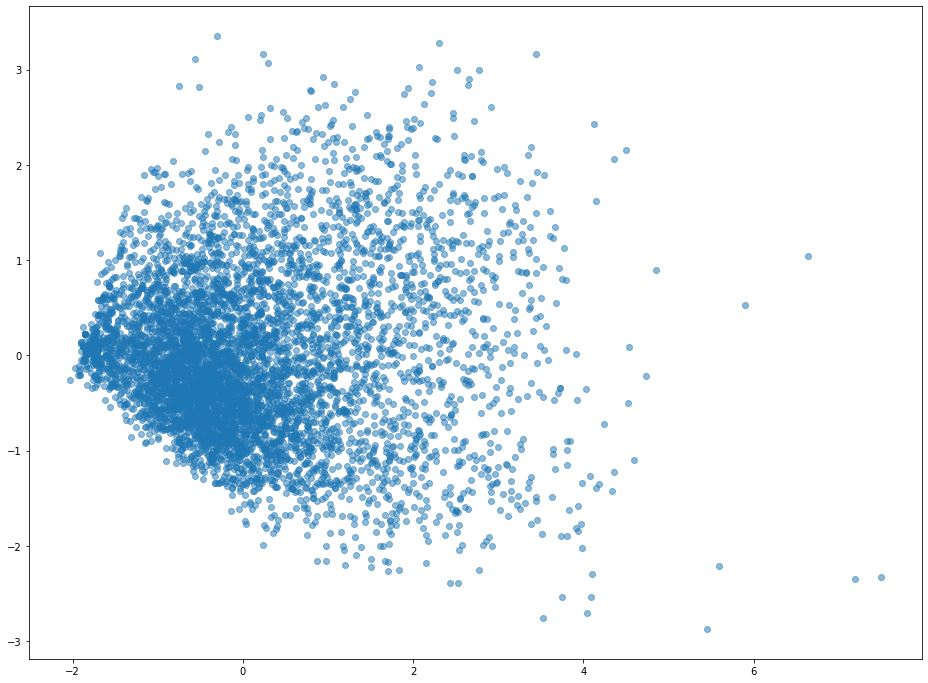

In [ ]:
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    #c=np.where(link_labels_train == 1, "b", "r"),
    alpha=0.5
)
plt.savefig('/content/drive/My Drive/Colab Notebooks/DSLab/eval/images/emb.jpeg')

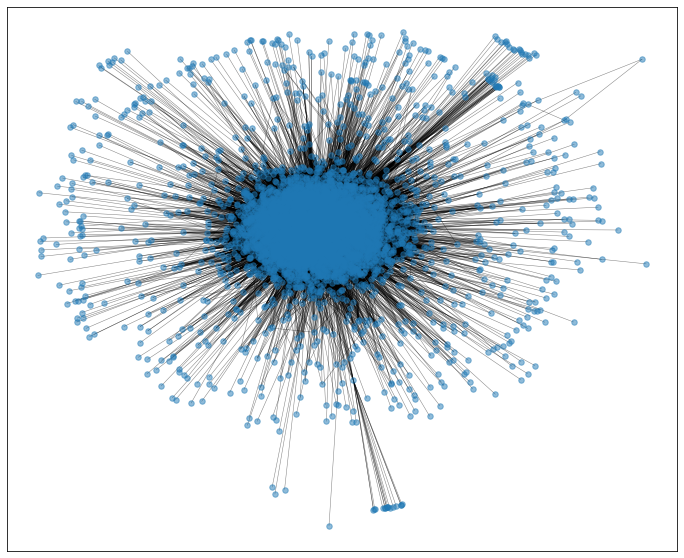

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(1, figsize=(12, 10))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos,alpha=0.5, node_size=30)
nx.draw_networkx_edges(G, pos,width=0.5,alpha=0.5)
#nx.draw_networkx_labels(graph_train, pos, font_size=1)
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/DSLab/eval/images/graph.jpeg')

###**Make ROC curve**

In [ ]:
def plot_roc_curve(y_true,y_pred):
  fpr, tpr, thresholds = roc_curve(y_true,y_pred, pos_label=1)
  auc_roc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic on Validation Set')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1.1], [0, 1.1],'r--')
  plt.xlim([0, 1.1])
  plt.ylim([0, 1.1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

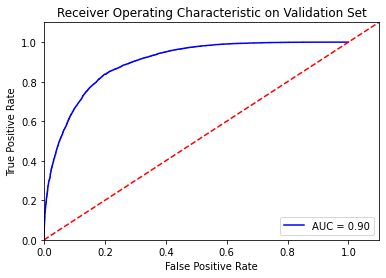

In [ ]:
plot_roc_curve(link_label_val,sigmoid_val_pred)

In [ ]:
testdata = EdgeDataset(examples_test,link_labels_test)
test_loader = DataLoader(testdata, batch_size=batch_s, shuffle=False)

In [ ]:
g_test = DGLGraph()
g_test.from_networkx(graph_test)
g_test.readonly()
test_preds = []
test_true = []
test_losses = []
for i,Data in enumerate(test_loader):
  node_pairs, labels_test = Data
  with torch.no_grad():
    test_loss, test_pred = model.predict(g_test.to(device),torch.FloatTensor(features).cuda(), torch.tensor(node_pairs).cuda(), labels_test.float().cuda())
    
    test_losses.append(test_loss)
    test_pred = test_pred.detach().to("cpu").numpy()
    #test_pred = 1*(test_pred>0.5)
    
    test_preds = np.append(test_preds, test_pred)
    test_true = np.append(test_true,labels_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
test_roc = roc_auc_score(test_true, test_preds)
test_ap = average_precision_score(test_true,test_preds)
print("Test ROC AUC Score = {:.4f}\nTest Average Precision Score = {:.4f}".format(test_roc,test_ap))

Test ROC AUC Score = 0.8974
Test Average Precision Score = 0.8878


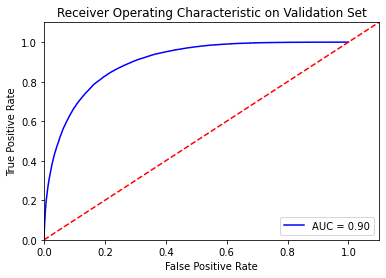

In [ ]:
plot_roc_curve(test_true,test_preds)

In [ ]:
precision, recall, thresholds = precision_recall_curve(test_true, test_preds)

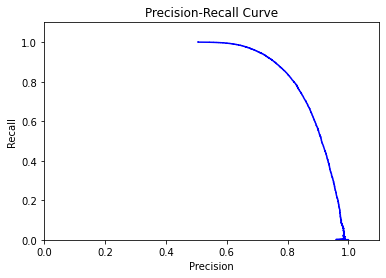

In [ ]:
plt.title('Precision-Recall Curve')
plt.plot(precision,recall, 'b')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

In [ ]:
cr = classification_report(test_true,test_preds.round())

In [ ]:
print(cr)

              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80     53049
         1.0       0.78      0.87      0.82     53049

    accuracy                           0.81    106098
   macro avg       0.82      0.81      0.81    106098
weighted avg       0.82      0.81      0.81    106098

